# GAN for MNIST dataset

In [1]:
%matplotlib inline
import torch
from torch import nn, optim
from torch.utils.data import DataLoader

from torchvision.datasets import MNIST
from torchvision.transforms import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt

### Preprocessing the MNIST dataset

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,), std=(0.5,))  # Convert the range of the input from [0,1] to [-1,1]
])

In [ ]:
# Load in the dataset - Use the pre-download training dataset
real_dataset = MNIST(
    root="../Lectures",
    transform=transform,
    train=True,
    download=False
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 16.5MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.94MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.95MB/s]


In [4]:
# Create the data loader
real_loader = DataLoader(real_dataset, batch_size=128, shuffle=True)

In [5]:
def rescaled_images(imgs):
    """
    Rescale the image's values to be between [0,1]
    """
    imgs = (imgs + 1) / 2
    return imgs

### Create the model

In [41]:
class MNIST_Generator(nn.Module):
    def __init__(self, latent_dims, num_outs, hidden_sizes):
        """
        The generator for the GAN
        """
        super(MNIST_Generator, self).__init__()
        # Make sure the numbers of hiddens units provided match the network's length
        assert len(hidden_sizes) == 3

        # ANN for generating images
        self.net = nn.Sequential(
            nn.Linear(latent_dims, hidden_sizes[0]),
            nn.LeakyReLU(),
            nn.BatchNorm1d(num_features=hidden_sizes[0], momentum=0.7),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_sizes[1], momentum=0.7),
            nn.Linear(hidden_sizes[1], hidden_sizes[2]),
            nn.LeakyReLU(),
            nn.BatchNorm1d(hidden_sizes[2], momentum=0.7),
            nn.Linear(hidden_sizes[2], num_outs),
            nn.Tanh()
        )

    def forward(self, X):
        outs = self.net(X)
        shape = int(np.sqrt(outs.size(1)).item())
        outs = outs.view(X.size(0), 1, shape, shape)
        return outs

In [36]:
class MNIST_Discriminator(nn.Module):
    def __init__(self, num_ins, hidden_sizes):
        """
        The discriminator for the GAN. Note that the first 2 entries for hidden_sizes
        will be used for CNN (body), while the last 2 will be used for the ANN (head).
        """
        super(MNIST_Discriminator, self).__init__()
        assert len(hidden_sizes) == 2

        self.fc = nn.Sequential(
            nn.Linear(num_ins, hidden_sizes[0]),
            nn.LeakyReLU(),
            nn.Linear(hidden_sizes[0], hidden_sizes[1]),
            nn.LeakyReLU(),
            nn.Linear(hidden_sizes[1], 1)
            # Sigmoid here
        )

    def forward(self, X):
        # Predict
        outs = self.fc(X)
        return outs

In [22]:
def configure(generator, discriminator, device, lr=0.0002):
    generator.to(device)
    discriminator.to(device)
    d_optimizer = optim.Adam(discriminator.parameters(), lr, betas=(0.5, 0.999))
    g_optimizer = optim.Adam(generator.parameters(), lr, betas=(0.5, 0.999))
    criterion = nn.BCEWithLogitsLoss()
    return criterion, d_optimizer, g_optimizer

In [32]:
def train_GAN(D, G, d_optim, g_optim, criterion, device, real_loader, latent_dim, num_epochs, train_gen_iter):
    reals = torch.ones(128, 1).to(device)
    fakes = torch.zeros(128, 1).to(device)

    d_history = torch.zeros(num_epochs)
    g_history = torch.zeros(num_epochs)

    for epoch in range(num_epochs):
        epoch_d_loss = []
        # Train the discriminator
        for inputs, _ in real_loader:
            n = inputs.size(0)
            inputs = inputs.to(device)

            # Train with real images
            d_outs = D(inputs.view(n, -1))
            d_loss_real = criterion(d_outs, reals[:n])

            # Train with fake images
            latent_data = torch.randn(n, latent_dim).to(device)
            g_outs = G(latent_data)
            d_outs = D(g_outs.view(n, -1))
            d_loss_fake = criterion(d_outs, fakes[:n])

            # average loss
            d_loss = 0.5 * (d_loss_fake + d_loss_real)
            d_optim.zero_grad()
            g_optim.zero_grad()
            d_loss.backward()
            d_optim.step()

            epoch_d_loss.append(d_loss.item())

            # Train the generator (multiple times)
            g_epoch_loss = []
            for _ in range(train_gen_iter):
                latent_data = torch.randn(n, latent_dim).to(device)
                g_outs = G(latent_data)
                d_outs = D(g_outs.view(n, -1))
                g_loss = criterion(d_outs, reals[:n])

                d_optim.zero_grad()
                g_optim.zero_grad()
                g_loss.backward()
                g_optim.step()

                g_epoch_loss.append(g_loss.item())

        # Record the loss
        d_history[epoch] = np.mean(epoch_d_loss).item()
        g_history[epoch] = np.mean(g_epoch_loss).item()

        print(f"Epoch {epoch}")
        # Record the generated images for tracking performance improvement
        if epoch % 50 == 0:
            noise = torch.randn(n, latent_dim).to(device)
            fake_images = G(noise)
            save_image(rescaled_images(fake_images), f"./images_mnist/{epoch}.png")

    return d_history, g_history

### Train the GAN

In [33]:
# Hyperparameters and some constants
num_epochs = 200
latent_dim = 100
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_outs_G = 28 * 28  # Number of pixels in the image
hidden_sizes_G = (256, 512, 1024)
hidden_sizes_D = (512, 256)

In [44]:
D = MNIST_Discriminator(28 * 28, hidden_sizes_D)
G = MNIST_Generator(latent_dim, num_outs_G, hidden_sizes_G)
criterion, d_optimizer, g_optimizer = configure(G, D, device)

In [12]:
from time import perf_counter

In [45]:
# Train the model
start = perf_counter()
d_history, g_history = train_GAN(D, G, d_optimizer, g_optimizer, criterion,
                                    device, real_loader, latent_dim, num_epochs, 2)
end = perf_counter()
f'Training takes {end-start:.2f}s'

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Epoch 30
Epoch 31
Epoch 32
Epoch 33
Epoch 34
Epoch 35
Epoch 36
Epoch 37
Epoch 38
Epoch 39
Epoch 40
Epoch 41
Epoch 42
Epoch 43
Epoch 44
Epoch 45
Epoch 46
Epoch 47
Epoch 48
Epoch 49
Epoch 50
Epoch 51
Epoch 52
Epoch 53
Epoch 54
Epoch 55
Epoch 56
Epoch 57
Epoch 58
Epoch 59
Epoch 60
Epoch 61
Epoch 62
Epoch 63
Epoch 64
Epoch 65
Epoch 66
Epoch 67
Epoch 68
Epoch 69
Epoch 70
Epoch 71
Epoch 72
Epoch 73
Epoch 74
Epoch 75
Epoch 76
Epoch 77
Epoch 78
Epoch 79
Epoch 80
Epoch 81
Epoch 82
Epoch 83
Epoch 84
Epoch 85
Epoch 86
Epoch 87
Epoch 88
Epoch 89
Epoch 90
Epoch 91
Epoch 92
Epoch 93
Epoch 94
Epoch 95
Epoch 96
Epoch 97
Epoch 98
Epoch 99
Epoch 100
Epoch 101
Epoch 102
Epoch 103
Epoch 104
Epoch 105
Epoch 106
Epoch 107
Epoch 108
Epoch 109
Epoch 110


'Training takes 3192.23s'

### Examine how the generator works

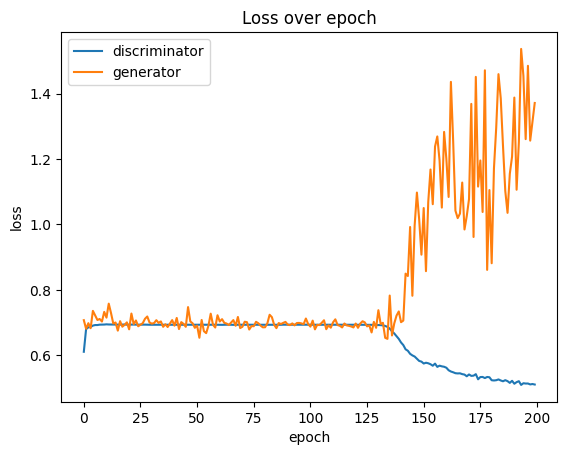

In [46]:
# Plot the losses
plt.title("Loss over epoch")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(d_history, label="discriminator")
plt.plot(g_history, label="generator")
plt.legend()
plt.show()

In [50]:
from skimage.io import imread

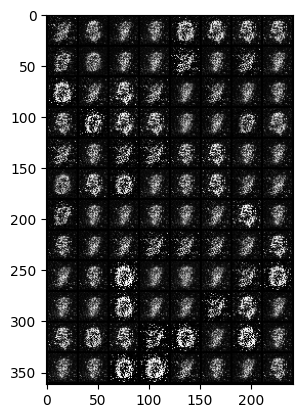

In [51]:
# Examine the "improvement" of the generator
img = imread("./images_mnist/0.png")
plt.imshow(img)

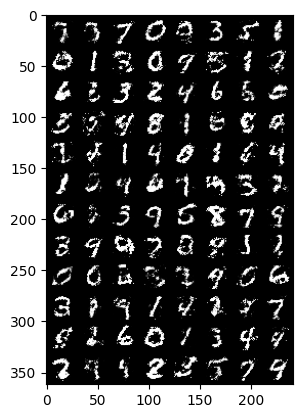

In [52]:
img2 = imread("./images_mnist/50.png")
plt.imshow(img2)

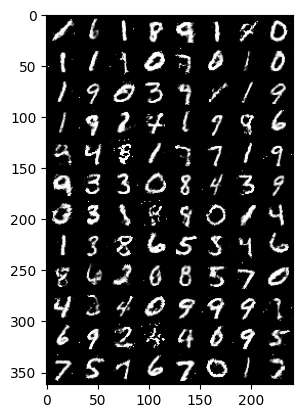

In [53]:
img3 = imread("./images_mnist/150.png")
plt.imshow(img3)

In [64]:
# Let's see how good the final generated images are
latent_data = torch.randn(128, latent_dim).to(device)
fake_images = G(latent_data)
save_image(rescaled_images(fake_images), f"./images_mnist/final.png")

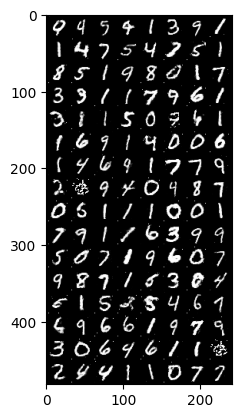

In [65]:
img4 = imread("./images_mnist/final.png")
plt.imshow(img4)